In [47]:
import numpy as np
from bch import BCH
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
assume = lambda x: 0 if abs(x - 0) < abs(x - 1) else 1
wherediff = lambda a, b: np.where(a != b)[0]

In [156]:
np.random.seed(123)
n, t = 63, 10
bch = BCH(n, t)
k = bch.k
print("speed = {:.2} ({}/{})".format(k/n,k,n))
print(f"k = {k}")
n_tests = 100
U = np.random.randint(0, 2, (n_tests, k))
V = bch.encode(U)
W = np.copy(V)
nums_err = np.random.randint(1, t + 1, n_tests)
err_idx_list = []
for i, n_err in enumerate(nums_err):
    if n_err > 0:
        rng = np.arange(n)
        np.random.shuffle(rng)
        err_idx = rng[:n_err]
        err_idx_list.append(err_idx)
        W[i, err_idx] ^= 1
Vd1 = bch.decode(W, method='pgz')
Vd2 = bch.decode(W, method='euclid')
for vd1, vd2, w, u, err_idx in zip(Vd1, Vd2, W, U, err_idx_list):
    for vd, method in zip([vd1, vd2], ['pgz', 'euclid']):
        if np.isnan(vd).any():
            print(f"{method} refused")
        else: 
            restored_idx = np.where(vd != w)[0]
            if set(restored_idx) == set(err_idx):
                print(f"{method} succeeded")
            else:
                print(f"{method} incorrect: was {err_idx}, found {restored_idx}")
        if len(err_idx) > t:
            print("(there was more errors than t)")
    print(np.array_equal(u, vd1[:k]))


speed = 0.29 (18/63)
k = 18
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True
pgz succeeded
euclid succeeded
True


In [329]:
n_tests = 10000

In [411]:
def gen_U_eqbits(n_tests, k):
    """
    сгенерировать м-цу из n_tests сбщ длины k,
    в которой значения 0 и 1 распределены равномерно
    """
    return np.random.choice(2, (n_tests, k))

def gen_U_eqnorms(n_tests, k):
    """
    сгенерировать м-цу из n_tests сбщ длины k,
    в которой кол-ва единиц в одном сообщении распределены равномерно
    
    но во всей матрице в итоге биты встречаются с одинаковой вероятностью
    """
    n_ones_list = np.random.randint(0, k + 1, n_tests)
    U = np.array([
        np.concatenate((np.ones(n_ones, dtype=int),
                        np.zeros(k - n_ones, dtype=int)))
        for n_ones in n_ones_list
    ])
    for u in U:
        np.random.shuffle(u)
    return U

In [618]:
# amt - мощность шума
# если amt = 1.0, то ошибок в сообщении не происходит
# для значений amt из [1, 3] и для значений n (для бчх-кода) 
#   измерим 99-й перцентиль количеств ошибок по сообщениям
#   (т.е. найдем такое t, чтобы только в 1% сообщений возникало больше ошибок, чем t)
# когда будем проверять работу бчх-кодов для разных n и t, будем выбирать такое значение
#   мощности шума, чтобы почти во всех сообщениях (за редким исключением)
#   происходило до t ошибок (а в исключениях можем "поправить" кол-во ошибок до t)
# далее видно, что найденная зависимость при фиксированном n - логарифмическая,
#   но неясно, с каким сдвигом и степенью, причем эти параметры различны для различных n

In [604]:
percentiles_for_n = []
n_list = [7, 15, 31, 63, 127]
for n in n_list:
    percent = 99
    n_tests = 10000
    V = gen_U_eqnorms(n_tests, n)
    amts = np.arange(1, 3, 0.025)
    percentiles = []
    for amt in amts:
        noise = (np.random.rand(n_tests, n) - 0.5) * amt
        W = np.vectorize(assume)(V + noise)
        n_err_list = [len(wherediff(v, w)) for v, w in zip(V, W)]
        percentile = np.percentile(n_err_list, percent)
        percentiles.append(percentile)
        print('.', end='')
    print('*')
    percentiles_for_n.append(percentiles)
percentiles_for_n = np.array(percentiles_for_n).astype(int)

................................................................................*
................................................................................*
................................................................................*
................................................................................*
................................................................................*


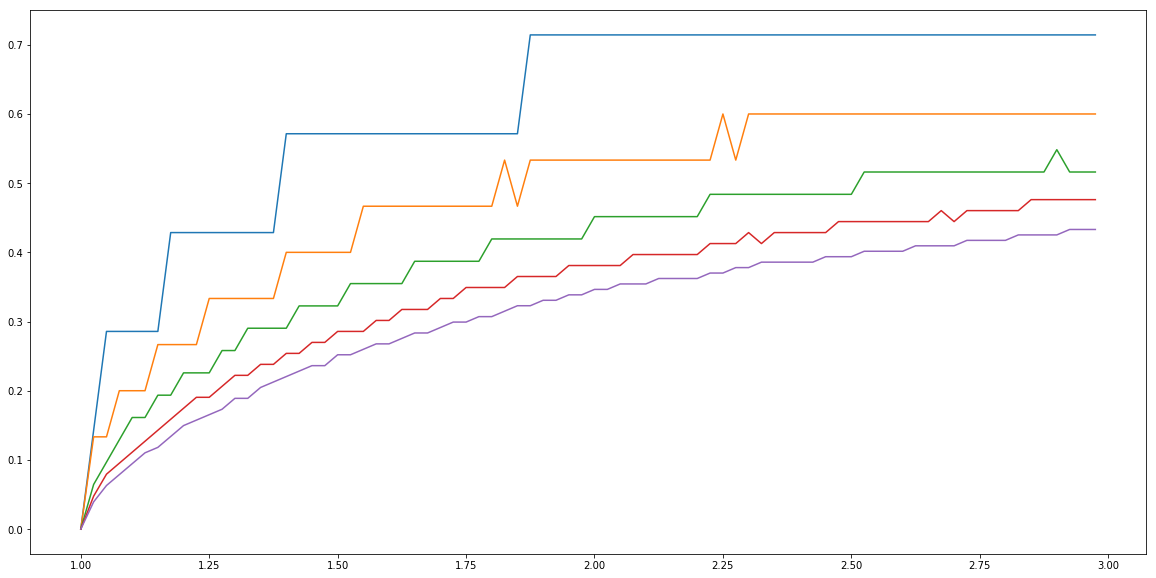

In [617]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
for n, percentiles in zip(n_list, percentiles_for_n):
    plt.plot(amts, percentiles / n)

In [554]:
amt_err_table = np.array(list(zip(amts, percentiles)))
amt_err_table

array([[1.        , 0.        ],
       [1.025     , 0.03137255],
       [1.05      , 0.04705882],
       [1.075     , 0.06666667],
       [1.1       , 0.07843137],
       [1.125     , 0.09019608],
       [1.15      , 0.10196078],
       [1.175     , 0.11372549],
       [1.2       , 0.1254902 ],
       [1.225     , 0.1372549 ],
       [1.25      , 0.14509804],
       [1.275     , 0.15686275],
       [1.3       , 0.16470588],
       [1.325     , 0.17254902],
       [1.35      , 0.18039216],
       [1.375     , 0.18823529],
       [1.4       , 0.19607843],
       [1.425     , 0.20392157],
       [1.45      , 0.21176471],
       [1.475     , 0.21568627],
       [1.5       , 0.22352941],
       [1.525     , 0.23137255],
       [1.55      , 0.23529412],
       [1.575     , 0.24313725],
       [1.6       , 0.24705882],
       [1.625     , 0.25098039],
       [1.65      , 0.25494118],
       [1.675     , 0.2627451 ],
       [1.7       , 0.26666667],
       [1.725     , 0.27058824],
       [1.

In [289]:
amt=2
noise = (np.random.rand(n_tests, n) - 0.5) * amt
W = np.vectorize(assume)(V + noise)

In [256]:
n_err_list = []
n_overdrives = 0
for i, (v, w) in enumerate(zip(V, W)):
    err_idx = wherediff(v, w)
    n_err = len(err_idx)
    if n_err > t:
        n_overdrives += 1
        np.random.shuffle(err_idx)
        W[i, err_idx[t : ]] ^= 1
        n_err = t
        if len(wherediff(v, W[i])) != t:
            raise Exception("programmer error")
    n_err_list.append(n_err)
print(n_overdrives / n_tests)

0.04


In [257]:
max(n_err_list)

10

(array([ 1.,  5.,  1., 16., 15., 28., 16.,  5.,  6.,  7.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

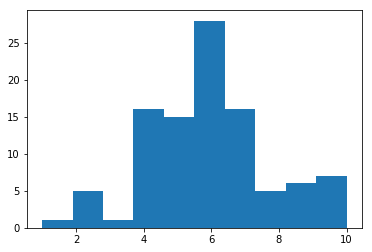

In [258]:
plt.hist(n_err_list)